In [11]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
from matplotlib import pyplot as plt
from qiskit.primitives import StatevectorSampler
from qiskit.quantum_info import PauliList

In [2]:
theta = Parameter("$\\theta$")

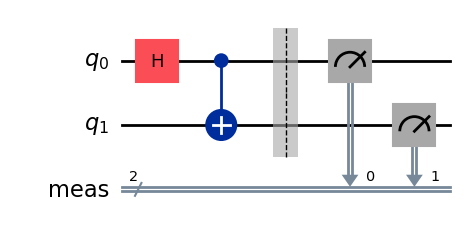

In [97]:
chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0)
chsh_circuit.cx(0, 1)
#chsh_circuit.h(0)
#chsh_circuit.h(1)
chsh_circuit.measure_all()
chsh_circuit.draw('mpl')

In [5]:
def _paulis2inds(paulis) -> list[int]:
    """Convert PauliList to diagonal integers.
    These are integer representations of the binary string with a
    1 where there are Paulis, and 0 where there are identities.
    """
    # Treat Z, X, Y the same
    nonid = paulis.z | paulis.x

    # bits are packed into uint8 in little endian
    # e.g., i-th bit corresponds to coefficient 2^i
    packed_vals = np.packbits(nonid, axis=1, bitorder="little")
    power_uint8 = 1 << (8 * np.arange(packed_vals.shape[1], dtype=object))
    inds = packed_vals @ power_uint8
    return inds.tolist()


def _parity(integer: int) -> int:
    """Return the parity of an integer"""
    return bin(integer).count("1") % 2

In [6]:
def _pauli_expval_with_variance(counts, paulis) -> tuple[np.ndarray, np.ndarray]:
    """Return array of expval and variance pairs for input Paulis.
    Note: All non-identity Pauli's are treated as Z-paulis, assuming
    that basis rotations have been applied to convert them to the
    diagonal basis.
    """
    # Diag indices
    size = len(paulis)
    diag_inds = _paulis2inds(paulis)

    expvals = np.zeros(size, dtype=float)
    denom = 0  # Total shots for counts dict
    for bin_outcome, freq in counts.items():
        split_outcome = bin_outcome.split(" ", 1)[0] if " " in bin_outcome else bin_outcome
        outcome = int(split_outcome, 2)
        denom += freq
        for k in range(size):
            coeff = (-1) ** _parity(diag_inds[k] & outcome)
            expvals[k] += freq * coeff

    # Divide by total shots
    expvals /= denom

    # Compute variance
    variances = 1 - expvals**2
    return expvals, variances

In [98]:
sampler = StatevectorSampler()

job = sampler.run([chsh_circuit], shots = 10000)
data_pub = job.result()[0].data
counts = data_pub.meas.get_counts()

observable = [PauliList(["XZ"])]

val, var = _pauli_expval_with_variance(counts, observable[0])

In [99]:
val

array([1.])

In [100]:
var

array([0.])

In [1]:
number_of_phases = 50
phases = [2 * np.pi * i / number_of_phases for i in range(number_of_phases)]
individual_phases = [[ph] for ph in phases]
from qiskit.quantum_info import SparsePauliOp
observable = SparsePauliOp.from_list([("ZZ", 1), ("ZX", -1), ("XZ", 1), ("XX", 1)])


NameError: name 'np' is not defined

In [40]:
from qiskit.primitives import StatevectorEstimator

In [41]:
estimator = StatevectorEstimator()

In [42]:
pub = (chsh_circuit, observable, individual_phases)

In [43]:
job = estimator.run([pub])

In [44]:
result = job.result()[0].data.evs

In [45]:
print(result)

[ 2.          1.32163526  0.52583743 -0.31668336 -1.13106545 -1.84494741
 -2.39489769 -2.73205081 -2.82644922 -2.66970521 -2.27574618 -1.67957712
 -0.93417026 -0.10575827  0.73205081  1.50481396  2.14386778  2.59242955
  2.81064257  2.77911766  2.50065596]


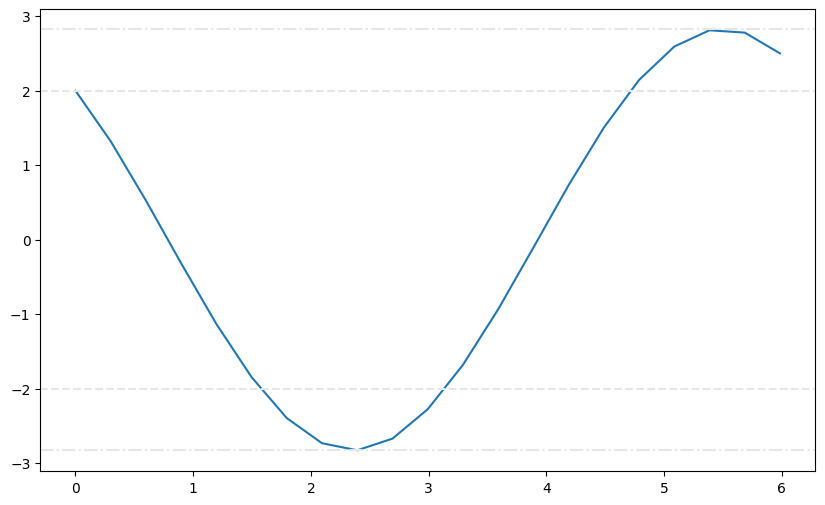

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(individual_phases, result)
ax.axhline(y=2, color="0.9", linestyle="--")
ax.axhline(y=-2, color="0.9", linestyle="--")

ax.axhline(y=np.sqrt(2) * 2, color="0.9", linestyle="-.")
ax.axhline(y=-np.sqrt(2) * 2, color="0.9", linestyle="-.")

In [48]:
for i in range(len(result)):
    if result[i] > 2 or result[i] < -2:
        print(f'Angle: {individual_phases[i]}\n Value: {result[i]}')
        print("---------")

Angle: [1.7951958020513104]
 Value: -2.3948976922762757
---------
Angle: [2.0943951023931953]
 Value: -2.7320508075688767
---------
Angle: [2.3935944027350806]
 Value: -2.826449219201491
---------
Angle: [2.6927937030769655]
 Value: -2.669705214039954
---------
Angle: [2.9919930034188504]
 Value: -2.275746184802606
---------
Angle: [4.787188805470161]
 Value: 2.1438677815352083
---------
Angle: [5.086388105812047]
 Value: 2.5924295460211986
---------
Angle: [5.385587406153931]
 Value: 2.8106425686535257
---------
Angle: [5.6847867064958155]
 Value: 2.7791176647592333
---------
Angle: [5.983986006837701]
 Value: 2.5006559603940905
---------
